# Part IV: Prediction and evaluation

## Content:
1. Basic settings
2. Load trained model
3. Prediction and evaluation
4. SHAP

## 1. Basic settings

In [149]:
import pickle
from pathlib import Path

import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import shap
from lightgbm import LGBMRegressor

In [150]:
nums_features = 45
SALES_DATA_PATH = Path("../data/preprocessed-data/sales_data_preprocessed.csv")
X_VAL_DATA_PATH = Path(f"../data/validation-data/X_val_{nums_features}_features.feather")
Y_VAL_DATA_PATH = Path(f"../data/validation-data/y_val_{nums_features}_features.feather")

In [151]:
df_sales = pd.read_csv(SALES_DATA_PATH, parse_dates=["date"])
X_val = pd.read_feather(X_VAL_DATA_PATH).set_index(keys=["index"])
y_val = pd.read_feather(Y_VAL_DATA_PATH).set_index(keys=["index"])

## 2. Load trained model

In [152]:
def load_model(file_path):
    """
    Load a machine learning model from a file.

    Parameters:
    - file_path: The file path from where the model will be loaded.

    Returns:
    - The loaded model.
    """
    try:
        with open(file_path, "rb") as file:
            model = pickle.load(file)
            print(f"Sklearn model loaded from {file_path}")
    except (pickle.UnpicklingError, FileNotFoundError):
        # If loading as scikit-learn model fails or the file is not found,
        # assume it is a LightGBM model (scikit-learn API)
        model = lgb.Booster(model_file=file_path)
        print(f"LightGBM (scikit-learn API) model loaded from {file_path}")

    return model

In [153]:
model_version = "01"
model_path= f"../model/sales_forecasting_model_{nums_features}_features_v{model_version}.txt"
gbm_model = load_model(model_path)

LightGBM (scikit-learn API) model loaded from ../model/sales_forecasting_model_45_features_v01.txt


In [154]:
gbm_model.params

{'boosting': 'gbdt',
 'objective': 'regression',
 'metric': ['l2'],
 'tree_learner': 'serial',
 'device_type': 'cpu',
 'num_iterations': 100,
 'learning_rate': 0.0900121,
 'num_leaves': 73,
 'num_threads': 10,
 'deterministic': False,
 'force_col_wise': False,
 'force_row_wise': False,
 'histogram_pool_size': -1,
 'max_depth': -1,
 'min_data_in_leaf': 20,
 'min_sum_hessian_in_leaf': 0.001,
 'bagging_fraction': 1,
 'pos_bagging_fraction': 1,
 'neg_bagging_fraction': 1,
 'bagging_freq': 0,
 'bagging_seed': 3,
 'feature_fraction': 0.923002,
 'feature_fraction_bynode': 1,
 'feature_fraction_seed': 2,
 'extra_trees': False,
 'extra_seed': 6,
 'early_stopping_round': 0,
 'first_metric_only': False,
 'max_delta_step': 0,
 'lambda_l1': 0,
 'lambda_l2': 0,
 'linear_lambda': 0,
 'min_gain_to_split': 0,
 'drop_rate': 0.1,
 'max_drop': 50,
 'skip_drop': 0.5,
 'xgboost_dart_mode': False,
 'uniform_drop': False,
 'drop_seed': 4,
 'top_rate': 0.2,
 'other_rate': 0.1,
 'min_data_per_group': 100,
 'max

## 3. Prediction and evaluation

In [155]:
# Filter data for validation period
validation_data = df_sales.loc[
    (df_sales["date"] >= "2017-10-01") & (df_sales["date"] <= "2017-12-31"), :
]

# Create a DataFrame for predictions
df_prediction = pd.DataFrame(
    {
        "date": validation_data["date"].values,
        "store": validation_data["store"].values,
        "item": validation_data["item"].values,
        "real_sales": y_val.sales,
        "pred_sales": gbm_model.predict(X_val),
    }
)

In [156]:
df_prediction.head()

,date,store,item,real_sales,pred_sales
index,,,,,
319500,2017-10-01,1,1,30.0,29.464715
319501,2017-10-02,1,1,45.0,49.359581
319502,2017-10-03,1,1,76.0,83.446413
319503,2017-10-04,1,1,133.0,119.255838
319504,2017-10-05,1,1,101.0,115.931476


In [157]:
def plot_sales_predictions(
    df_prediction, store_id=1, nrows=10, ncols=5, figsize=(20, 30)
):
    # Filter data for the specified store
    df_sample = df_prediction[df_prediction["store"] == store_id]

    # Create subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)

    for item_id, ax in zip(range(1, nrows * ncols + 1), axes.flat):
        # Filter data for the specified item in the store
        df2plot = df_sample[df_sample["item"] == item_id]

        # Plot real and predicted sales
        df2plot[["date", "real_sales"]].plot(x="date", y="real_sales", c="b", ax=ax)
        df2plot[["date", "pred_sales"]].plot(
            x="date", y="pred_sales", marker=".", c="r", ax=ax
        )

        # Set title as item ID
        ax.set_title(f"Item {item_id}")

    plt.tight_layout()

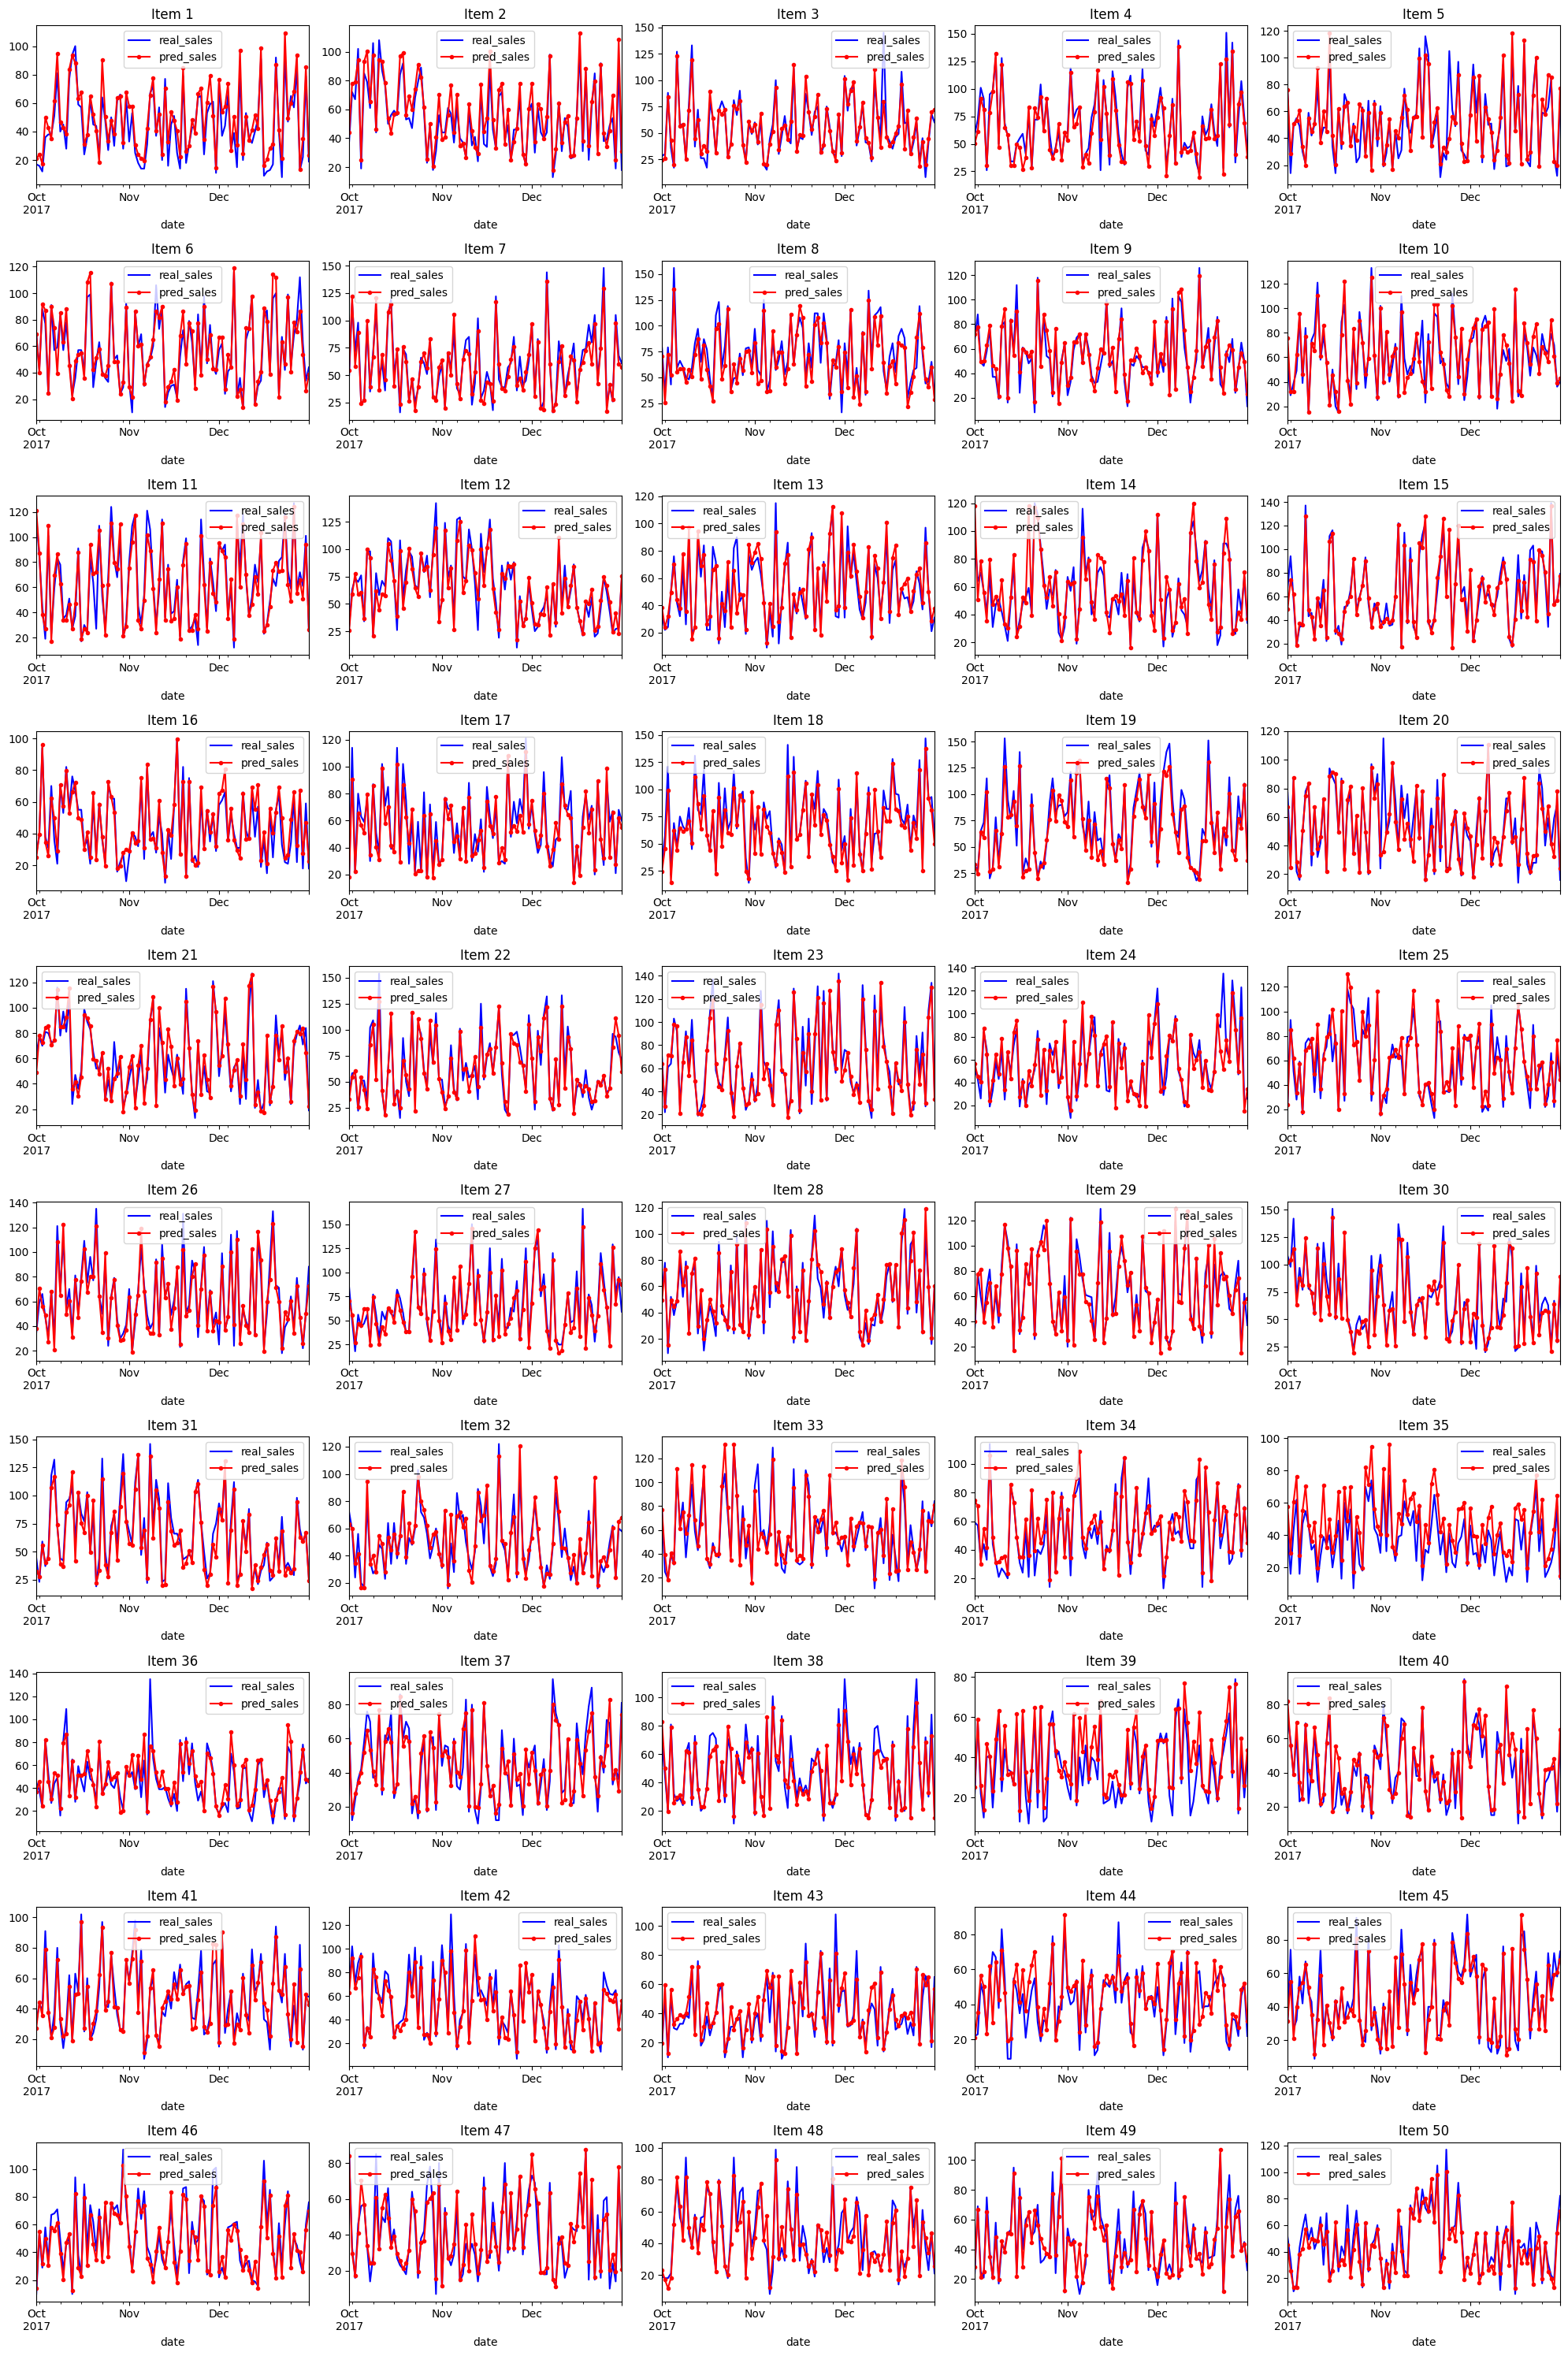

In [158]:
store_id = 10
plot_sales_predictions(df_prediction, store_id=store_id)

## 4. SHAP

### 4.1. Overal

In [159]:
explainer = shap.Explainer(gbm_model)
shap_values_valid = explainer(X_val)

len(shap_values_valid)

46000

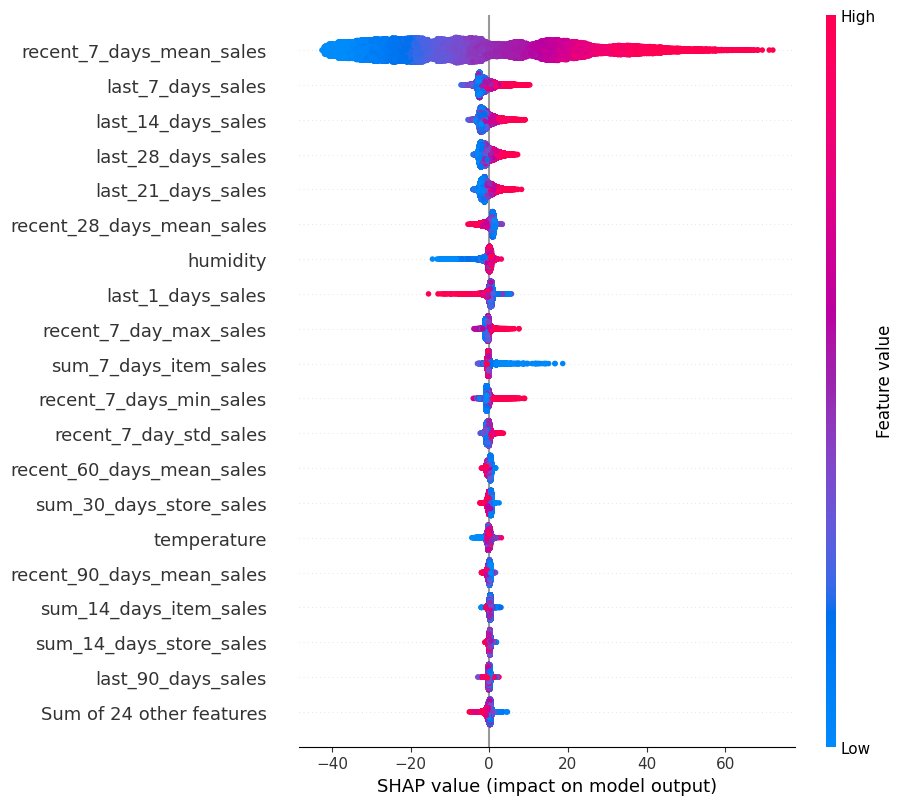

In [160]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values_valid, max_display=20)

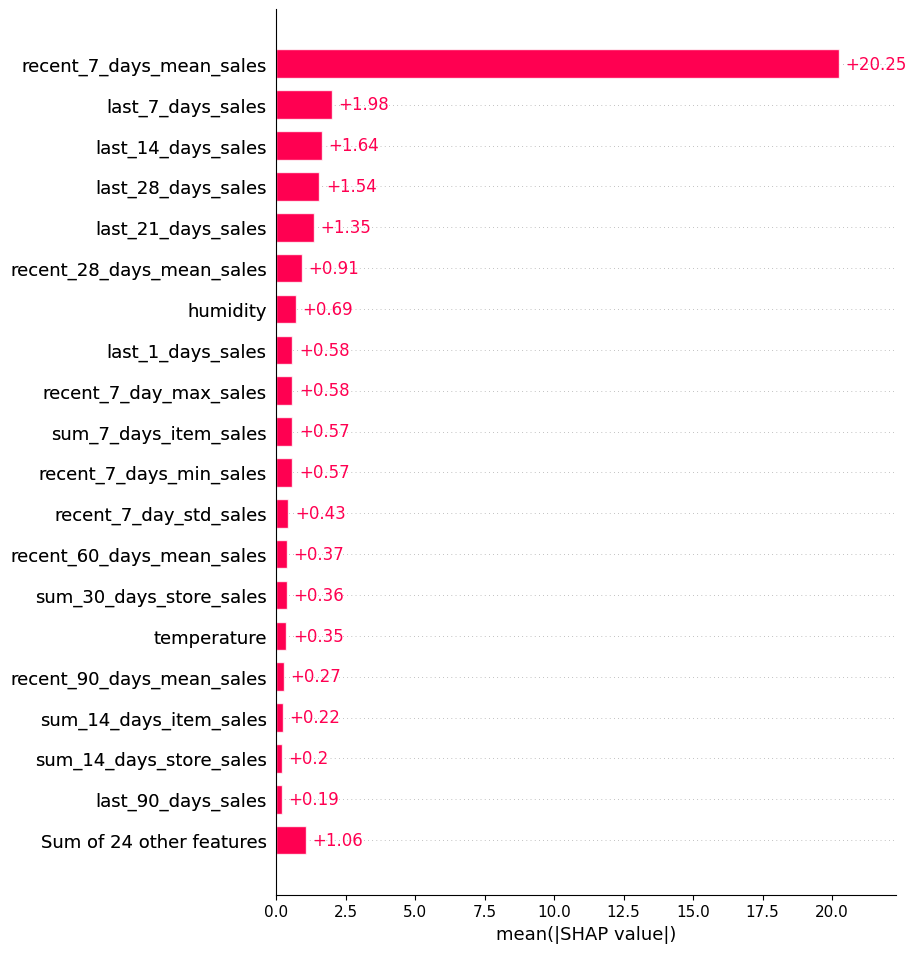

In [162]:
# absolute mean shap
shap.plots.bar(shap_values_valid, max_display=20)

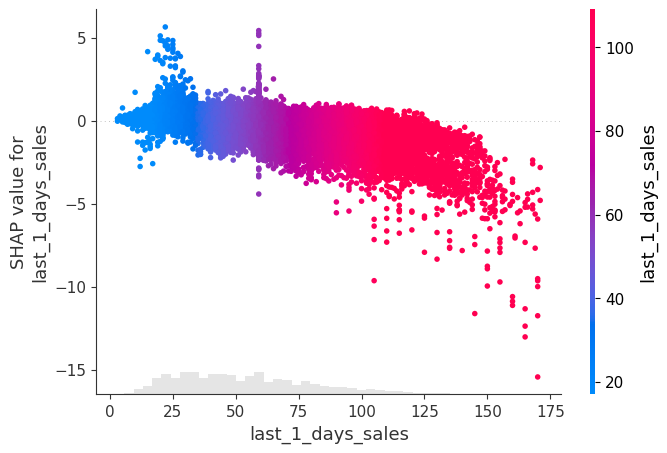

In [186]:
feature_name = "last_1_days_sales"
shap.plots.scatter(shap_values_valid[:, feature_name], color=shap_values_valid[:, feature_name])

### 4.2. Check sample

In [165]:
target_id = 20

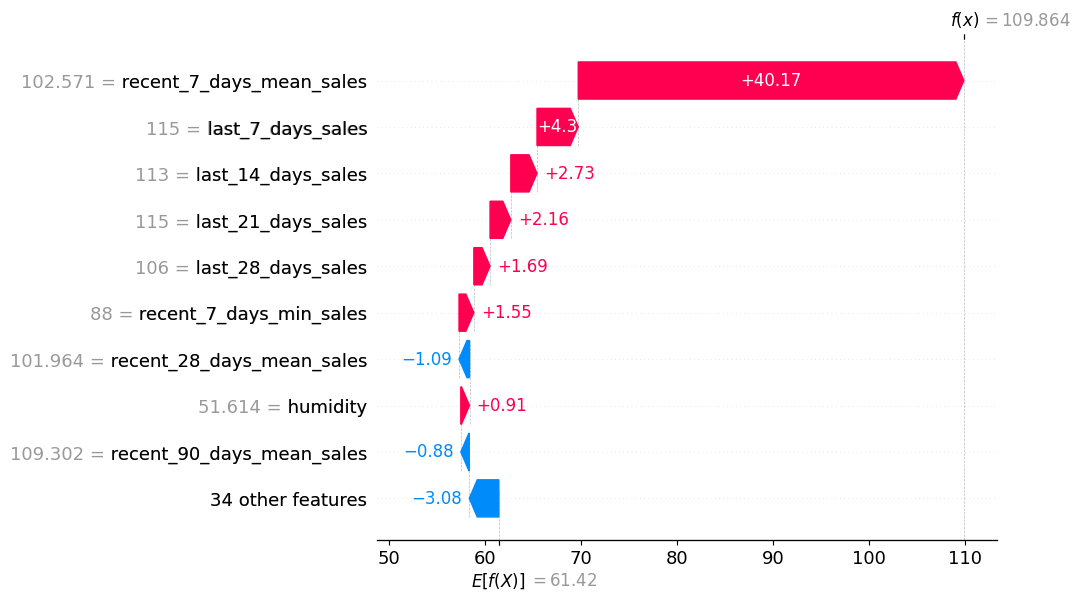

In [166]:
shap.waterfall_plot(shap_values=shap_values_valid[target_id], max_display=10)

In [167]:
X_val.iloc[target_id]

store                             8.000000
item                             12.000000
last_1_days_sales               103.000000
last_7_days_sales               115.000000
last_14_days_sales              113.000000
last_21_days_sales              115.000000
last_28_days_sales              106.000000
last_90_days_sales              110.000000
last_180_days_sales              94.000000
recent_7_days_mean_sales        102.571429
recent_7_days_min_sales          88.000000
recent_7_day_max_sales          116.000000
recent_7_day_std_sales           10.517559
recent_14_days_mean_sales       101.714286
recent_14_days_min_sales         77.000000
recent_14_day_max_sales         117.000000
recent_14_day_std_sales          11.691079
recent_28_days_mean_sales       101.964286
recent_28_days_min_sales         68.000000
recent_28_day_max_sales         133.000000
recent_28_day_std_sales          14.211321
recent_60_days_mean_sales       105.085706
recent_60_days_min_sales         59.142340
recent_60_d

In [168]:
store_id = 8
item_id = 12
keys=["store","item"]
grouped = X_val.groupby(keys)
df_sample = grouped.get_group((store_id, item_id))
# df_sample

In [170]:
df_sample.recent_7_days_mean_sales.describe()

count     92.000000
mean      88.108690
std       12.080027
min       66.714286
25%       73.785714
50%       93.500000
75%       96.821429
max      106.285714
Name: recent_7_days_mean_sales, dtype: float64

In [171]:
df_prediction.iloc[target_id]

date          2017-10-21 00:00:00
store                           1
item                            1
real_sales                  104.0
pred_sales             109.864019
Name: 319520, dtype: object

In [74]:
# shap_values_valid[target_id]

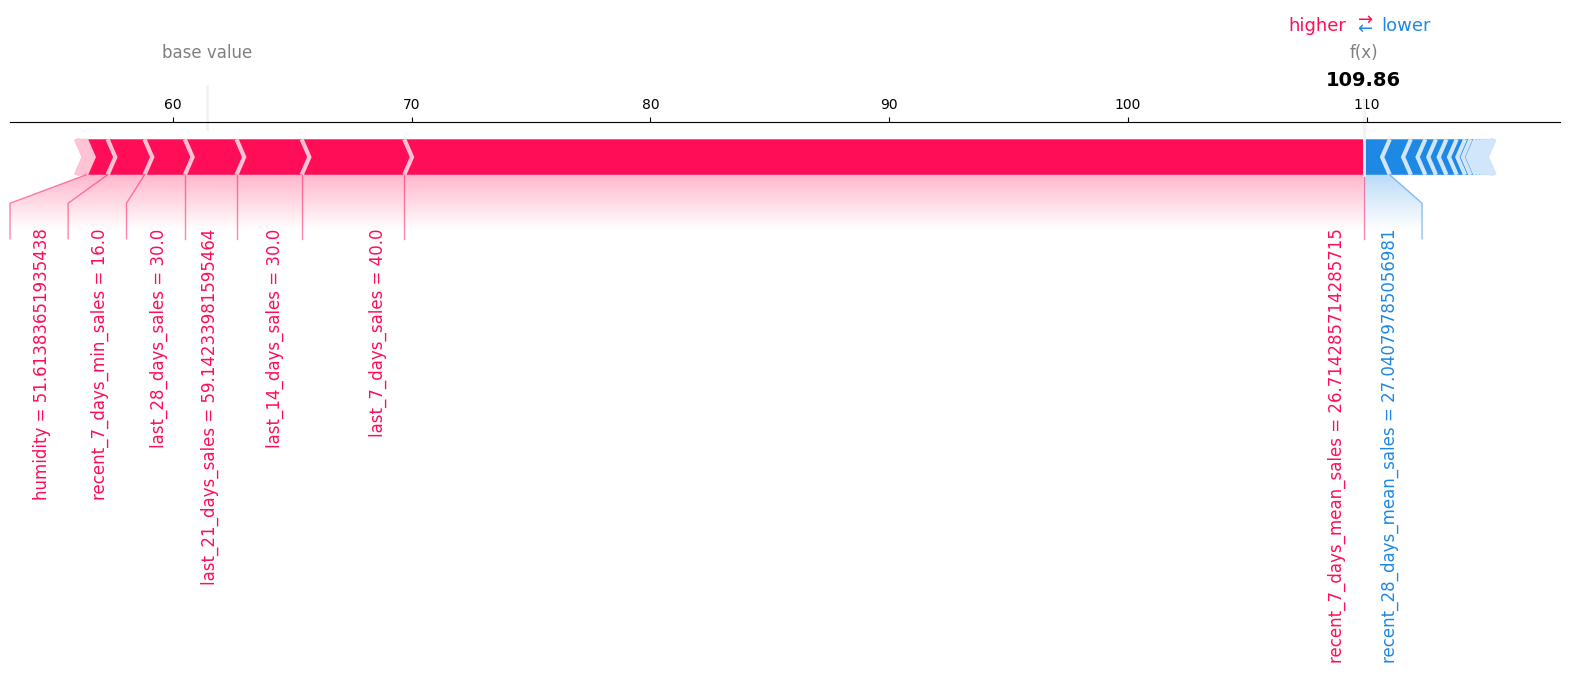

In [173]:
# visualize the first prediction's explanation with a force plot
shap.force_plot(
    shap_values_valid[target_id], 
    shap_values_valid[0,:], 
    X_val.iloc[0,:],
    text_rotation=90,
    matplotlib=True
) 

### 4.3. Samples analysis

In [174]:
X_val.columns

Index(['store', 'item', 'last_1_days_sales', 'last_7_days_sales',
       'last_14_days_sales', 'last_21_days_sales', 'last_28_days_sales',
       'last_90_days_sales', 'last_180_days_sales', 'recent_7_days_mean_sales',
       'recent_7_days_min_sales', 'recent_7_day_max_sales',
       'recent_7_day_std_sales', 'recent_14_days_mean_sales',
       'recent_14_days_min_sales', 'recent_14_day_max_sales',
       'recent_14_day_std_sales', 'recent_28_days_mean_sales',
       'recent_28_days_min_sales', 'recent_28_day_max_sales',
       'recent_28_day_std_sales', 'recent_60_days_mean_sales',
       'recent_60_days_min_sales', 'recent_60_day_max_sales',
       'recent_60_day_std_sales', 'recent_90_days_mean_sales',
       'recent_90_days_min_sales', 'recent_90_day_max_sales',
       'recent_90_day_std_sales', 'sum_7_days_store_sales',
       'mean_7_days_store_sales', 'sum_7_days_item_sales',
       'mean_7_days_item_sales', 'sum_14_days_store_sales',
       'mean_14_days_store_sales', 'sum_14_

In [175]:
num_samples = 500
X_samples = shap.utils.sample(X_val, num_samples)
explainer = shap.Explainer(gbm_model.predict, X_samples)
shap_values = explainer(X_samples)

PermutationExplainer explainer: 501it [00:33, 10.46it/s]                                                                                                                                  


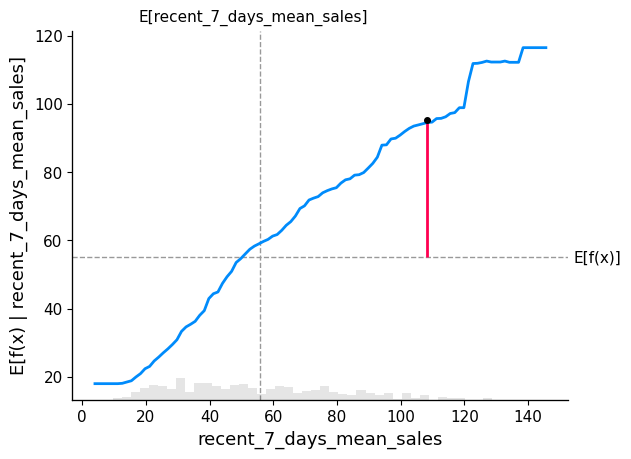

In [177]:
# make a standard partial dependence plot with a single SHAP value overlaid
sample_ind = 10
feature_name = "recent_7_days_mean_sales"

fig, ax = shap.partial_dependence_plot(
    feature_name,
    gbm_model.predict,
    X_samples,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
    shap_values=shap_values[sample_ind : sample_ind + 1, :],
)

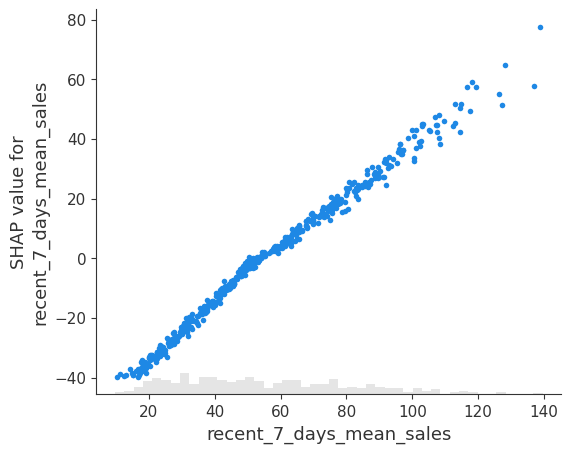

In [178]:
shap.plots.scatter(shap_values[:, feature_name])

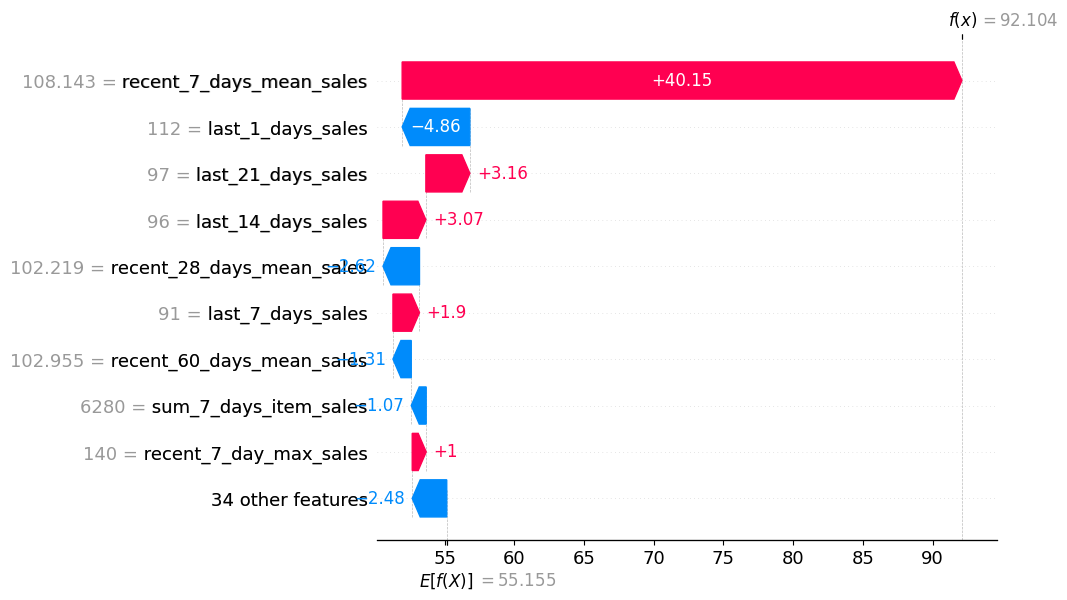

In [179]:
# the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind])

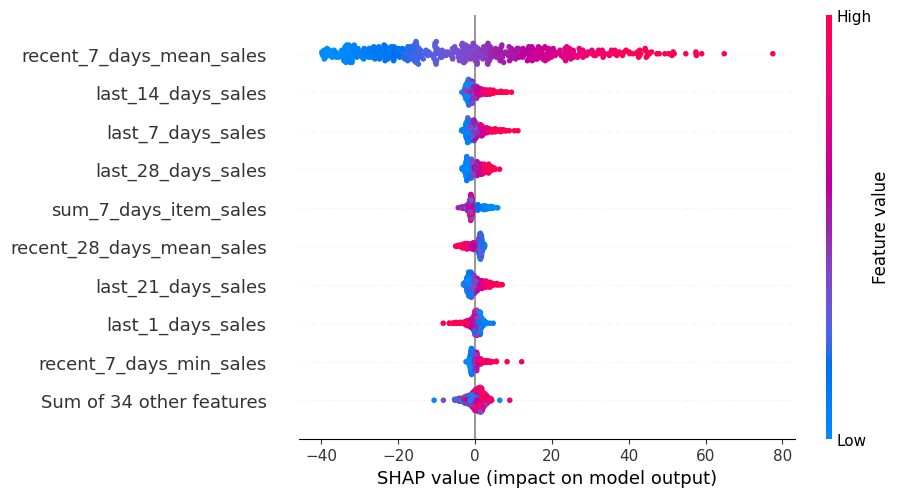

In [180]:
# the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.plots.beeswarm(shap_values)

In [182]:
# the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.plots.force(shap_values[:100])